## Web Crawing
- 웹 페이지에서 데이터를 수집하는 방법에 대해서 학습

### 웹크롤링 방법

#### 웹페이지의 종류
- 정적인 페이지 : 웹 브라우져에 화면이 한번 뜨면 이벤트에 의한 화면의 변경이 없는 페이지 
- 동적인 페이지 : 웹 브라우져에 화면이 뜨고 이벤트가 발생하면 서버에서 데이터를 가져와 화면을 변경하는 페이지

#### requests 이용
- 받아오는 문자열에 따라 두가지 방법으로 구분
    - json 문자열로 받아서 파싱하는 방법 : 주로 동적 페이지 크롤링할때 사용 
    - html 문자열로 받아서 파싱하는 방법 : 주로 정적 페이지 크롤링할때 사용
        
#### selenium 이용
- 브라우져를 직접 열어서 데이터를 받는 방법

#### 크롤링 방법에 따른 속도
- requests json > requests html > selenium

### Crwaling Naver Stock Datas
- 네이버 증권 사이트에서 주가 데이터 수집
- 수집할 데이터 : 일별 kospi, kosdaq 주가, 일별 환율(exchange rate) 데이터
- 데이터 수집 절차
    - 웹서비스 분석 : url
    - 서버에 데이터 요청 : request(url) > response : json(str)
    - 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import requests

#### 1. 웹서비스 분석 : url
- pc 웹페이지가 복잡하면 mobile 웹페이지에서 수집

In [4]:
page, pagesize = 1, 20
url = f'https://m.stock.naver.com/api/index/KOSPI/price?pageSize={pagesize}&page={page}'
#print(url)

#### 2. 서버에 데이터 요청 : request(url) > response : json(str)
- response의 status code가 200이 나오는지 확인
- 403이나 500이 나오면 request가 잘못되거나 web server에서 수집이 안되도록 설정이 된것임
    - header 설정 또는 selenium 사용
- 200이 나오더라도 response 안에 있는 내용을 확인 > 확인하는 방법 : response.text

In [5]:
response = requests.get(url)
response, response.text[:200]

(<Response [200]>,
 '[{"localTradedAt":"2023-09-04","closePrice":"2,579.34","compareToPreviousClosePrice":"15.63","compareToPreviousPrice":{"code":"2","text":"상승","name":"RISING"},"fluctuationsRatio":"0.61","openPrice":"2')

#### 3. 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [6]:
type(response.text), type(response.json())

(str, list)

In [9]:
data = response.json()
kospi = pd.DataFrame(data)[['localTradedAt', 'closePrice']]
kospi.head()

,localTradedAt,closePrice
0,2023-09-04,"2,579.34"
1,2023-09-01,"2,563.71"
2,2023-08-31,"2,556.27"
3,2023-08-30,"2,561.22"
4,2023-08-29,"2,552.16"


#### 4. 함수로 만들기

In [27]:
def stock_crolling(mode = 'KOSPI', page = 1, pagesize = 60):
    url = f'https://m.stock.naver.com/api/index/{mode}/price?pageSize={pagesize}&page={page}'
    response = requests.get(url)
    data = response.json()
    
    return pd.DataFrame(data)[['localTradedAt', 'closePrice']]

In [28]:
kospi = stock_crolling('KOSPI')
kosdaq = stock_crolling('KOSDAQ')

#### 5. 원달러 환율 데이터 수집 : 실습

In [20]:
def won_dollar(page = 1, pagesize = 60):
    url = f'https://m.stock.naver.com/front-api/v1/marketIndex/prices?page={page}&category=exchange&reutersCode=FX_USDKRW&pageSize={pagesize}'
    response = requests.get(url)
    data = response.json()['result']
    
    return pd.DataFrame(data)[['localTradedAt', 'closePrice']]

In [24]:
usd = won_dollar()

#### 6. 시각화

In [39]:
df = kospi.copy()
df.columns = ['date', 'kospi']
df['kosdaq'] = kosdaq['closePrice']
df['usd'] = usd['closePrice']
df.head()

,date,kospi,kosdaq,usd
0,2023-09-04,"2,584.55",919.16,"1,320.00"
1,2023-09-01,"2,563.71",919.74,"1,321.50"
2,2023-08-31,"2,556.27",928.40,"1,325.00"
3,2023-08-30,"2,561.22",923.81,"1,322.00"
4,2023-08-29,"2,552.16",916.24,"1,325.00"


In [40]:
df['kospi'] = df['kospi'].apply(lambda data: data.replace(',', '')).astype('float')
df['kosdaq'] = df['kosdaq'].apply(lambda data: data.replace(',', '')).astype('float')
df['usd'] = df['usd'].apply(lambda data: data.replace(',', '')).astype('float')

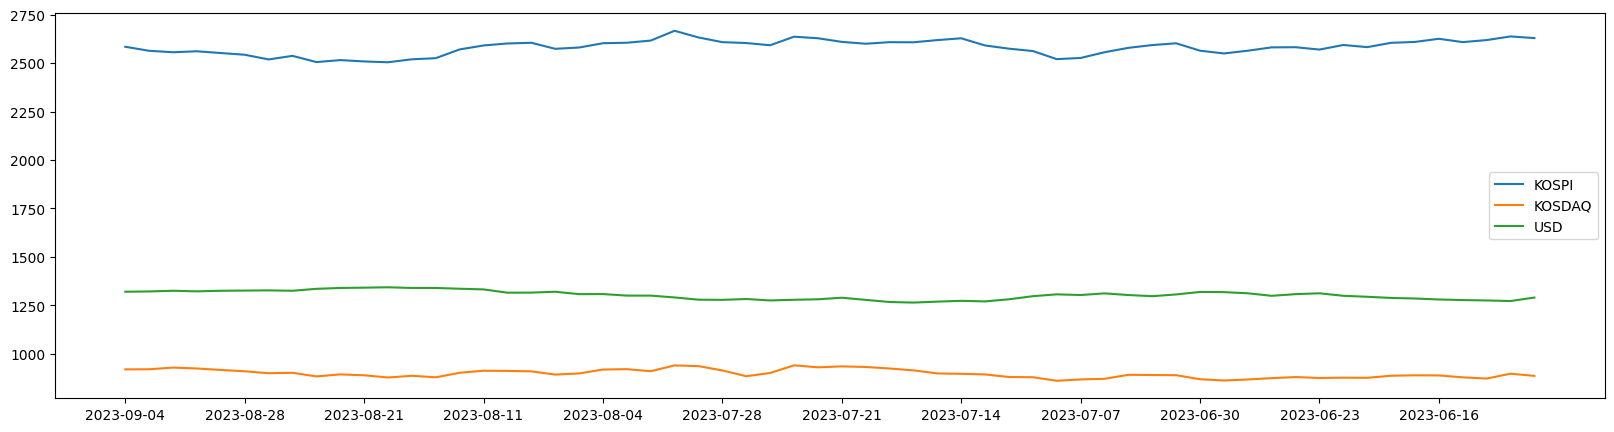

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(df['date'], df['kospi'], label='KOSPI')
plt.plot(df['date'], df['kosdaq'], label='KOSDAQ')
plt.plot(df['date'], df['usd'], label='USD')
plt.xticks(df['date'].values[::5])
plt.legend()
plt.show()

#### 7. 데이터 스케일링
- min max scaling


- $z = \frac{x_i - min(x)}{max(x) - min(x)} (0 \leqq z \leqq 1)$


- latex syntax : `https://jjycjnmath.tistory.com/117`

In [42]:
from sklearn.preprocessing import minmax_scale
minmax_scale(df['kospi'])

array([0.49240327, 0.36421234, 0.31844744, 0.34889586, 0.29316602,
       0.23934305, 0.09005352, 0.2040967 , 0.0061512 , 0.06913945,
       0.02645014, 0.        , 0.09442086, 0.13003629, 0.40825491,
       0.5336778 , 0.59703512, 0.61893338, 0.42738513, 0.46878268,
       0.60466261, 0.62059421, 0.68874946, 1.        , 0.78784524,
       0.63861721, 0.61087532, 0.54044412, 0.81171188, 0.76293289,
       0.64747493, 0.58885403, 0.63812512, 0.63431137, 0.70431199,
       0.76151812, 0.53349326, 0.43193701, 0.35670788, 0.09964938,
       0.13661807, 0.31857046, 0.45826413, 0.54628775, 0.60263271,
       0.36771852, 0.28000246, 0.36716491, 0.47296549, 0.47794796,
       0.40351848, 0.54868672, 0.48059298, 0.61764163, 0.64587562,
       0.74607861, 0.63997047, 0.70480408, 0.82087716, 0.76797687])

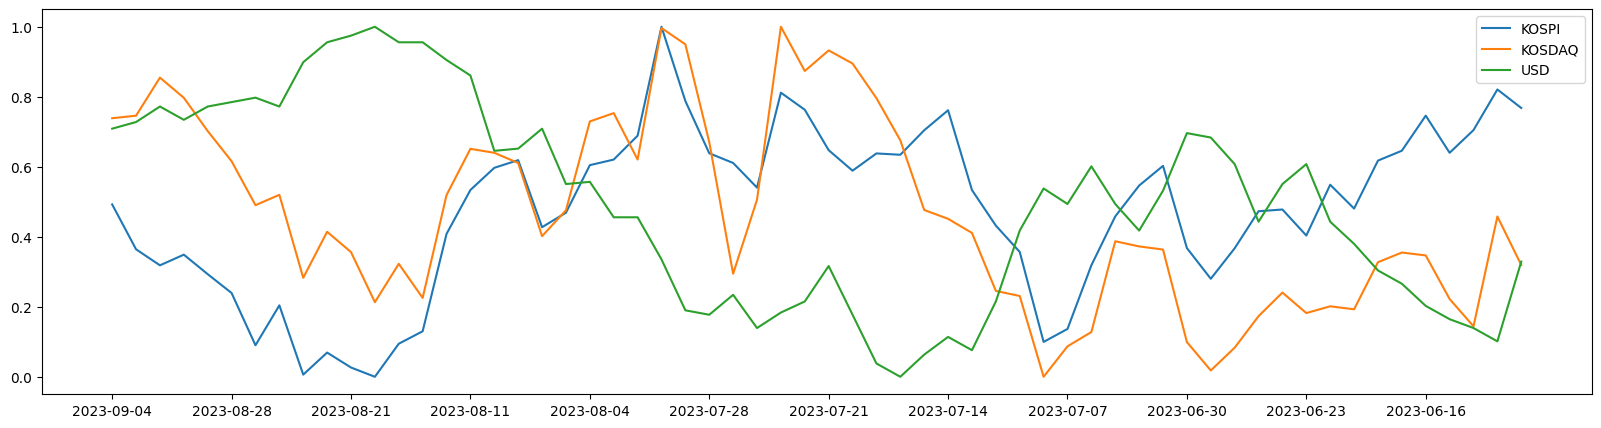

In [44]:
plt.figure(figsize=(20,5))
plt.plot(df['date'], minmax_scale(df['kospi']), label='KOSPI')
plt.plot(df['date'], minmax_scale(df['kosdaq']), label='KOSDAQ')
plt.plot(df['date'], minmax_scale(df['usd']), label='USD')
plt.xticks(df['date'].values[::5])
plt.legend()
plt.show()

#### 8. 상관관계 분석
- 피어슨 상관계수(Pearson Correlation Coefficient)
- 두 데이터 집합의 상관도를 분석할때 사용되는 지표
- 상관계수의 해석
    - -1에 가까울수록 서로 반대방향으로 움직임
    - 1에 가까울수록 서로 같은방향으로 움직임
    - 0에 가까울수록 두 데이터는 관계가 없음

In [45]:
df.corr()

,kospi,kosdaq,usd
kospi,1.000000,0.435544,-0.777750
kosdaq,0.435544,1.000000,-0.163863
usd,-0.777750,-0.163863,1.000000


### finance data reader package
- yahoo finance api를 사용한 주가 데이터 수집을 위한 package
- `https://financedata.github.io/posts/finance-data-reader-users-guide.html`